<a href="https://colab.research.google.com/github/RahulKumarSahDepp/salesForeCast-Prediction/blob/main/salesForecastPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Required Library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Loading the dataset

In [2]:
file_path = "/content/train.csv"
df = pd.read_csv(file_path)
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


 Data Analysis

In [4]:
df.shape

(9800, 18)

In [5]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [6]:
df.isnull()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9796,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9797,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9798,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Data Preprocessing/Data Visualization

In [7]:
#we will conver the column "Order Date" to date-time format so that we can use it for time-based Operations.
df["Order Date"] = pd.to_datetime(df["Order Date"], format = '%d/%m/%Y')


In [9]:
# Now we will group training data by Order Date and sum all sum for each day, creating time-series for daily-sales.
sales_per_date = df.groupby('Order Date')['Sales'].sum().reset_index()

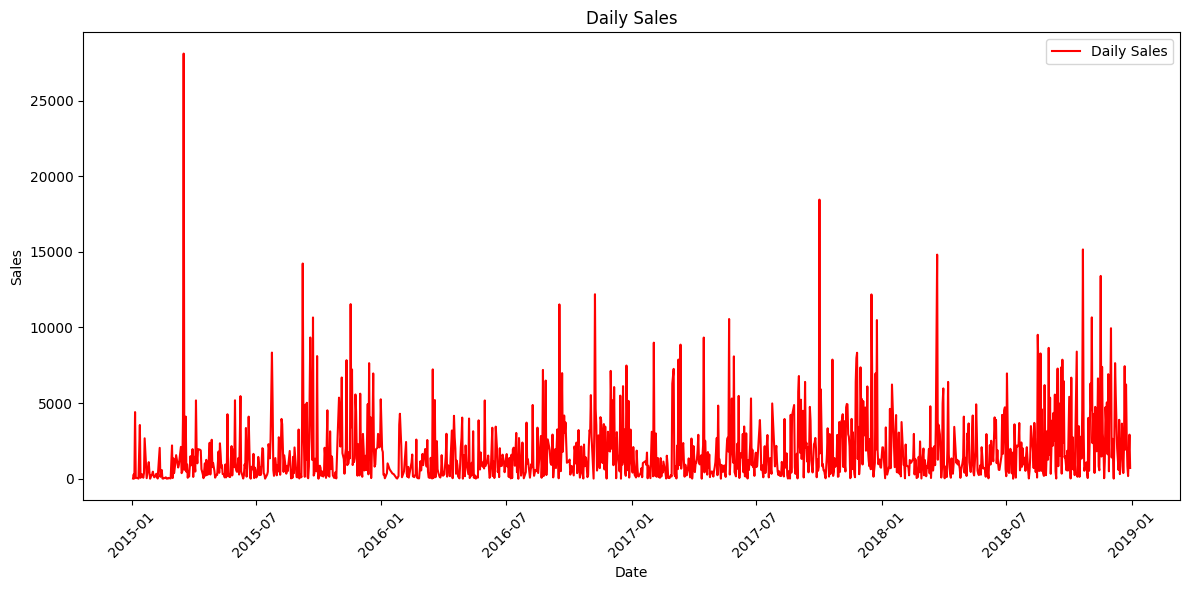

In [11]:
#As we have grouped the data by order data and sum all the sales per day , we will plot it and try to understand/visualize the data points
plt.figure(figsize=(12, 6))
plt.plot(sales_per_date["Order Date"], sales_per_date["Sales"], label = "Daily Sales", color = "red")
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation = 45) #rotates the labels on x-axis by 45 degree
plt.tight_layout() # ensures everything fits nicely within the figsize, prevent from labels overlapping
plt.show()

Feature Engineering

We will create lagged features to capture temporal patterns in the data,  Lag features help the model learn from the previous sales data to predict future sales.
Shift Operating in lagging introduce to  missing values so we will drop the row having missing values since droping some rows will not affect our model learning in this case.

In [13]:
def create_lagged_features(data, lag=1):
    lagged_data = df.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['Sales'].shift(i)
    return lagged_data

lag = 5
sales_with_lags = create_lagged_features(df[['Order Date', 'Sales']], lag)

sales_with_lags = sales_with_lags.dropna()

# Training the XGBoost model
*   XGBRegressor: Initializes an XGBoost model for regression tasks.
*   objective='reg:squarederror': indicates that we are solving a regression problem i.e predicting continuous sales values.
*   learning_rate (lr): Controls the step size at each iteration while moving toward a minimum of the loss function with smaller values leading to slower convergence.
*   n_estimators: The number of boosting rounds or trees to build with higher values improving model accuracy but potentially leading to overfitting.
*   max_depth: Defines the maximum depth of each decision tree controlling the complexity of the model. Deeper trees can model more complex patterns.

In [36]:
X = sales_with_lags.drop(columns=['Sales'])
Y = sales_with_lags['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Drop the 'Order Date' column as XGBoost cannot handle datetime objects directly
X_train = X_train.drop(columns=['Order Date'], errors='ignore')
X_test = X_test.drop(columns=['Order Date'], errors='ignore')

# Encode object columns using combined data to avoid unseen label error
from sklearn.preprocessing import LabelEncoder
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        # Fit on combined train + test to avoid unseen categories
        all_values = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
        le.fit(all_values)
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#Making Predictions and Evaluating the Model

In [37]:
import numpy as np
prediction_xgb = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction_xgb))
print(f"RMSE: {rmse:.2f}")

RMSE: 671.59


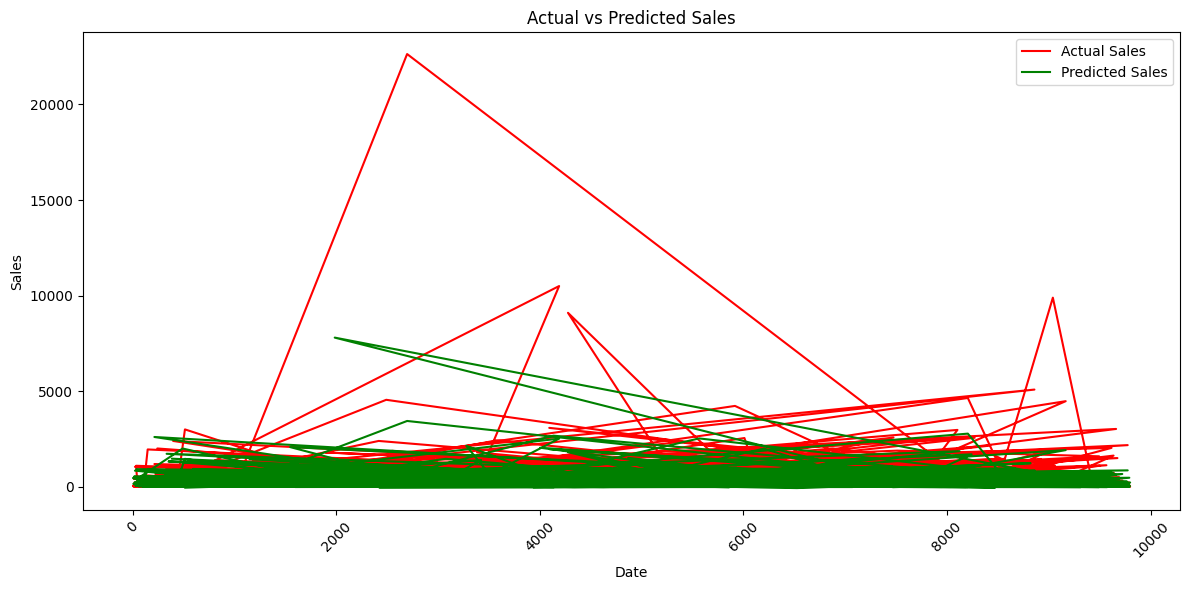

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Sales", color = "red")
plt.plot(y_test.index, prediction_xgb, label="Predicted Sales", color= "green")
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()